# Combine SCHISM output

This is the prototype for combining the multi-core output of SCHISM to one xarray datatet. This includes the construction of the grid references. It replaces autocombine_MPI_elfe.pl.
The example model used is the one of Jigsaw Setup Notebook.

In [3]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import glob
import pandas as pd
import xarray as xr
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
folder='/Users/brey/SCHISM/test_grid/'

## Read the global element index distribution to the cores  

In [4]:
gtol = glob.glob(folder+'outputs/global*')

In [5]:
gindx = pd.read_csv(gtol[0],header=None,delim_whitespace=True)

In [6]:
gindx = gindx.set_index(gindx.columns[0]) # set the global index as index

In [7]:
gindx.columns=['dist'] # rename the column to dist[ribution]

In [8]:
gindx.head()

,dist
0,
1,1
2,0
3,0
4,1
5,3


In [9]:
#one can choose the elements on node 0
node0 = gindx.loc[gindx.dist == 0]

In [10]:
node0.index

Int64Index([  2,   3,   9,  19,  24,  25,  27,  28,  33,  41,
            ...
            656, 662, 667, 669, 670, 677, 680, 683, 686, 695],
           dtype='int64', name=0, length=174)

## Read the global node index distribution to the cores  

In [11]:
gfiles = glob.glob(folder+'outputs/local*')
gfiles.sort()
gfiles

['/Users/brey/SCHISM/test_grid/outputs/local_to_global_0000',
 '/Users/brey/SCHISM/test_grid/outputs/local_to_global_0001',
 '/Users/brey/SCHISM/test_grid/outputs/local_to_global_0002',
 '/Users/brey/SCHISM/test_grid/outputs/local_to_global_0003']

In [12]:
#create a dict from filenames to identify parts in the dataframes below

keys=[]
for name in gfiles:
    keys.append('core{}'.format(name.split('/')[-1].split('_')[-1]))
keys

['core0000', 'core0001', 'core0002', 'core0003']

### Parsing the files

In [13]:
# We read from the first file the header (it is the sama for all)
header = pd.read_csv(gfiles[0],header=None,nrows=1,delim_whitespace=True,names=['ns_global','ne_global','np_global','nvrt','nproc','ntracers','T','S','GEN','AGE','SED3D','EcoSim','ICM','CoSINE','Feco','TIMOR','FABM'])
#for i in range(1,len(gfiles)):
#    header = pd.concat([header,pd.read_csv(gfiles[i],header=None,nrows=1,delim_whitespace=True)])

In [14]:
header = header.T # transpose for visual convenience 

In [15]:
header

,0
ns_global,1109
ne_global,702
np_global,407
nvrt,2
nproc,4
ntracers,2
T,1
S,1
GEN,0
AGE,0


In [16]:
#get the number of elems from all files
nels = []
for i in range(len(gfiles)):
    ne = pd.read_csv(gfiles[i],skiprows=2, header=None, nrows = 1)
    nels.append(ne.values.flatten()[0].astype(int))
nels

[174, 176, 176, 176]

In [17]:
#read and add them to pandas DataFrame 
frames=np.empty(len(gfiles),dtype=object)
for i in range(len(gfiles)):
    frames[i] = pd.read_csv(gfiles[i],skiprows=3,header=None, nrows=nels[i], names=['local','global_n'], delim_whitespace=True)

elems = pd.concat(frames,keys=keys)

elems.head()

local  global_n
core0000 0      1         2
         1      2         3
         2      3         9
         3      4        19
         4      5        24

In [18]:
elems.max()

local       176
global_n    702
dtype: int64

In [19]:
#get the number of nodes from all files
nq = []
for i in range(len(gfiles)):
    nn = pd.read_csv(gfiles[i],skiprows=nels[i] + 3, header=None, nrows = 1)
    nq.append(nn.values.flatten()[0].astype(int))
nq

[107, 112, 110, 115]

In [20]:
#read and add them to pandas DataFrame
nframes=np.empty(len(gfiles),dtype=object)
for i in range(len(gfiles)):
    nframes[i] = pd.read_csv(gfiles[i],skiprows=nels[i] + 4,header=None, nrows=nq[i], names=['local','global_n'], delim_whitespace=True)
    
nodes = pd.concat(nframes,keys=keys)

nodes.head()

local  global_n
core0000 0      1       218
         1      2       220
         2      3       355
         3      4       293
         4      5       305

In [21]:
nodes.max()

local       115
global_n    407
dtype: int64

In [22]:
#get the number of edges
nw = []
for i in range(len(gfiles)):
    nb = pd.read_csv(gfiles[i],skiprows=nels[i] + nq[i] + 4, header=None, nrows = 1)
    nw.append(nb.values.flatten()[0].astype(int))
nw

[280, 287, 285, 290]

In [23]:
#read and add them to pandas DataFrame
wframes=np.empty(len(gfiles),dtype=object)
for i in range(len(gfiles)):
    wframes[i] = pd.read_csv(gfiles[i],skiprows=nels[i] + nq[i] + 5,header=None, nrows=nw[i], names=['local','global_n'], delim_whitespace=True)
    
re = pd.concat(wframes,keys=keys)

re.head()

local  global_n
core0000 0      1         4
         1      2         5
         2      3         6
         3      4         7
         4      5         8

In [24]:
re.max()

local        290
global_n    1109
dtype: int64

In [25]:
#read secondary headers

h0 = pd.read_csv(gfiles[0],skiprows=nels[0] + nq[0] + nw[0] + 6, header=None, nrows = 1, delim_whitespace=True, names=['start_year','start_month','start_day','start_hour','utc_start'])

h1 = pd.read_csv(gfiles[0],skiprows=nels[0] + nq[0] + nw[0] + 7, header=None, nrows = 1, delim_whitespace=True, names = ['nrec','dtout','nspool','nvrt','kz','h0','h_s','h_c','theta_b','theta_f','ics'])


In [26]:
ztots = ['ztot_'+str(i) for i in range(1,h1.loc[:,'kz']-1)]

ztots

[]

In [27]:
sigmas = ['sigma_'+str(i) for i in range(h1.loc[:,'nvrt'] - h1.loc[:,'kz'] + 1) ]
sigmas

['sigma_0', 'sigma_1']

In [28]:
ztots + sigmas

['sigma_0', 'sigma_1']

In [29]:
#read secondary header
h2 = pd.read_csv(gfiles[0],skiprows=nels[0] + nq[0] + nw[0] + 8, header=None, nrows = 1, delim_whitespace=True, names=ztots + sigmas)

In [30]:
#combine headers
header2 = pd.concat([h0, h1, h2], axis=1)
#header2 = header2.T
header2

,start_year,start_month,start_day,start_hour,utc_start,nrec,dtout,nspool,nvrt,kz,h0,h_s,h_c,theta_b,theta_f,ics,sigma_0,sigma_1
0,2013,10,28,0.0,0.0,4,3600.0,9,2,1,0.5,1000000.0,40.0,1.0,0.0001,2,-1.0,0.0


In [31]:
#read lat/lon from all files
gframes=np.empty(len(gfiles),dtype=object)
for i in range(len(gfiles)):
    gframes[i] = pd.read_csv(gfiles[i],skiprows=nels[i] + nq[i] + nw[i] + 10, header=None, nrows = nq[i], delim_whitespace=True, names=['lon','lat','depth','kbp00'])
    
grid = pd.concat(gframes,keys=keys)

grid.head()

lon        lat   depth  kbp00
core0000 0 -78.240143  17.926964   838.0      1
         1 -78.295212  17.828188  1539.0      1
         2 -78.185257  17.831535   807.0      1
         3 -78.566040  17.382647   513.0      1
         4 -78.505302  17.517424   938.0      1

In [32]:
#read tessellation 
eframes=np.empty(len(gfiles),dtype=object)
for i in range(len(gfiles)):
    eframes[i] = pd.read_csv(gfiles[i],skiprows=nels[i] + nq[i] + nw[i] + nq[i] + 10, header=None, nrows = nels[i], delim_whitespace=True, names=['type','a','b','c'])
    
tri = pd.concat(eframes,keys=keys)

tri.head()

type   a   b   c
core0000 0     3   1   2   3
         1     3   4   5   6
         2     3   7   8   9
         3     3  10  11  12
         4     3  13  14  15

## Check grid 

In [33]:
for [a,b,c] in tri.loc['core0000',['a','b','c']].values[0:1]:
    print a,b,c
    [x1, y1] = grid.loc['core0000',['lon','lat']].values[a - 1]
    print(x1,y1)
    [x2, y2] = grid.loc['core0000',['lon','lat']].values[b - 1]
    print(x2,y2)
    [x3, y3] = grid.loc['core0000',['lon','lat']].values[c - 1]
    print(x3,y3)




1 2 3
(-78.2401428, 17.9269638)
(-78.2952118, 17.8281879)
(-78.185257, 17.8315353)


In [34]:
tri3 = tri.loc['core0000',['a','b','c']].values - 1 # for python index

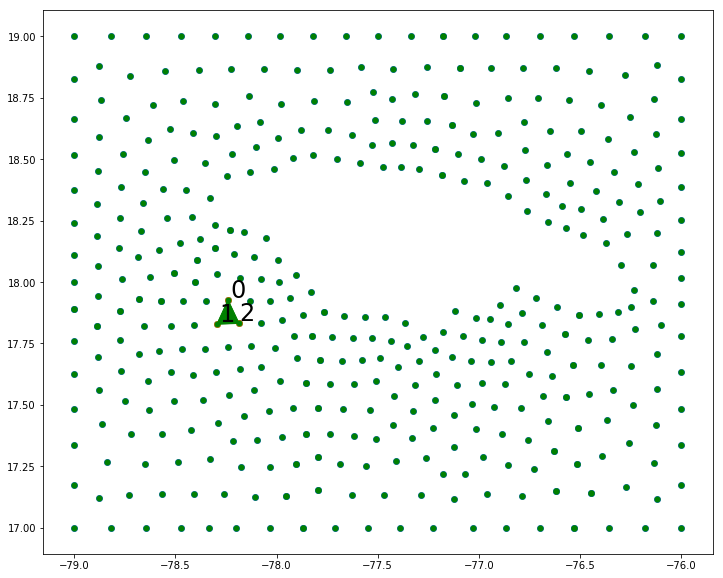

In [35]:
plt.figure(figsize=(12,10))
plt.scatter(grid.lon.values, grid.lat.values)
plt.triplot(grid.lon.values, grid.lat.values, tri3[:1], 'go-', lw=.5, markersize=5 )

w=np.array([[x1,y1],[x2,y2],[x3,y3]])
plt.scatter(w[:,0],w[:,1])
t1 = plt.Polygon(w[:3,:], color='g')
plt.gca().add_patch(t1)
plt.gca().annotate('0', xy=(w[0,0], w[0,1]),xytext=(w[0,0]+.01, w[0,1]+.01),xycoords='data',size=24)
plt.gca().annotate('1', xy=(w[1,0], w[1,1]),xytext=(w[1,0]+.01, w[1,1]+.01),xycoords='data',size=24)
plt.gca().annotate('2', xy=(w[2,0], w[2,1]),xytext=(w[2,0], w[2,1]+.01),xycoords='data',size=24)

plt.show()

## Read Netcdf output files

In [36]:
files = glob.glob(folder+'outputs/schout_0*_*.nc')
files.sort()
files

['/Users/brey/SCHISM/test_grid/outputs/schout_0000_1.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0000_2.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0000_3.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0000_4.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0001_1.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0001_2.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0001_3.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0001_4.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0002_1.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0002_2.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0002_3.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0002_4.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0003_1.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0003_2.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0003_3.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_0003_4.nc']

In [37]:
#store them in a list
out=[]
for i in range(len(keys)):
    ifiles = [f for f in files if '{}_'.format(i) in f]
    out.append(xr.open_mfdataset(ifiles))

In [38]:
out[0] # example

<xarray.Dataset>
Dimensions:            (nSCHISM_hgrid_face: 174, nSCHISM_hgrid_node: 107, nSCHISM_vgrid_layers: 2, time: 12, two: 2)
Coordinates:
  * time               (time) float64 3.6e+03 7.2e+03 1.08e+04 1.44e+04 ...
Dimensions without coordinates: nSCHISM_hgrid_face, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, two
Data variables:
    wetdry_elem        (time, nSCHISM_hgrid_face) float32 dask.array<shape=(12, 174), chunksize=(4, 174)>
    zcor               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 dask.array<shape=(12, 107, 2), chunksize=(4, 107, 2)>
    elev               (time, nSCHISM_hgrid_node) float32 dask.array<shape=(12, 107), chunksize=(4, 107)>
    wind_speed         (time, nSCHISM_hgrid_node, two) float32 dask.array<shape=(12, 107, 2), chunksize=(4, 107, 2)>
    vertical_velocity  (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 dask.array<shape=(12, 107, 2), chunksize=(4, 107, 2)>
    temp               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_la

## Read the combined NetCDFs with autocombine_MPI_elfe.pl.

Run "autocombine_MPI_elfe.pl 0 3" on the model folder. 

In [41]:
cfiles = glob.glob(folder+'outputs/schout_0.nc') + glob.glob(folder+'outputs/schout_[!00]*.nc')
cfiles.sort()
cfiles

['/Users/brey/SCHISM/test_grid/outputs/schout_0.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_1.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_2.nc',
 '/Users/brey/SCHISM/test_grid/outputs/schout_3.nc']

In [42]:
gr = xr.open_mfdataset(cfiles[0], autoclose=True, drop_variables=['time'])

In [43]:
var = xr.open_mfdataset(cfiles[1:], autoclose=True, drop_variables=gr.variables.keys())

In [44]:
grf = xr.merge([gr,var])

In [45]:
grf

<xarray.Dataset>
Dimensions:                  (nMaxSCHISM_hgrid_face_nodes: 4, nSCHISM_hgrid_edge: 1109, nSCHISM_hgrid_face: 702, nSCHISM_hgrid_node: 407, nSCHISM_vgrid_layers: 2, one: 1, sigma: 2, time: 12, two: 2)
Coordinates:
  * sigma                    (sigma) float32 -1.0 0.0
  * time                     (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nMaxSCHISM_hgrid_face_nodes, nSCHISM_hgrid_edge, nSCHISM_hgrid_face, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, one, two
Data variables:
    SCHISM_hgrid             (one) int32 dask.array<shape=(1,), chunksize=(1,)>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<shape=(702, 4), chunksize=(702, 4)>
    SCHISM_hgrid_edge_nodes  (nSCHISM_hgrid_edge, two) int32 dask.array<shape=(1109, 2), chunksize=(1109, 2)>
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float32 dask.array<shape=(407,), chunksize=(407,)>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node)

## convert time to Timestamps

In [46]:
date = header2.loc[:,['start_year','start_month','start_day','start_hour','utc_start']]

In [47]:
date

,start_year,start_month,start_day,start_hour,utc_start
0,2013,10,28,0.0,0.0


In [48]:
date.columns=['year','month','day','hour','utc'] # rename the columns

In [49]:
date.year # check

0    2013
Name: year, dtype: int64

In [50]:
#set the start timestamp
sdate = pd.Timestamp(year=date.year.values, month=date.month.values, day=date.day.values, hour=date.hour.values, tz=date.utc.values)
sdate

Timestamp('2013-10-28 00:00:00')

In [51]:
out[0].time.values # output times in seconds

array([ 3600.,  7200., 10800., 14400., 18000., 21600., 25200., 28800.,
       32400., 36000., 39600., 43200.])

In [52]:
#get times as timestamps
times = pd.to_datetime(out[0].time.values, unit='s',
                   origin=sdate)
times

DatetimeIndex(['2013-10-28 01:00:00', '2013-10-28 02:00:00',
               '2013-10-28 03:00:00', '2013-10-28 04:00:00',
               '2013-10-28 05:00:00', '2013-10-28 06:00:00',
               '2013-10-28 07:00:00', '2013-10-28 08:00:00',
               '2013-10-28 09:00:00', '2013-10-28 10:00:00',
               '2013-10-28 11:00:00', '2013-10-28 12:00:00'],
              dtype='datetime64[ns]', freq=None)

## Get the grid (nodes) indices

Since there are ghost nodes due to the mpi split we need to sort out the duplicates. This is done with the global_n index which would be the same for repeat nodes.

### Find duplicates

In [53]:
nodes.global_n.duplicated(keep=False)

core0000  0      False
          1      False
          2      False
          3      False
          4      False
          5      False
          6      False
          7      False
          8      False
          9      False
          10      True
          11      True
          12     False
          13     False
          14     False
          15     False
          16      True
          17     False
          18      True
          19     False
          20     False
          21     False
          22     False
          23     False
          24     False
          25      True
          26      True
          27     False
          28     False
          29     False
                 ...  
core0003  85      True
          86     False
          87      True
          88     False
          89     False
          90     False
          91     False
          92     False
          93     False
          94     False
          95     False
          96      True
          9

#### Check

In [54]:
nodes.loc['core0000', 10] # choose one from the above True nodes to check

local       11
global_n    13
Name: (core0000, 10), dtype: int64

In [55]:
nodes.loc[nodes.global_n==13] # find the duplicate indices equal to the global_n

,,local,global_n
core0000,10,11,13
core0002,46,47,13


It seems that the node 13 is common to core0000 and core00002

In [56]:
grid.loc['core0000',10], grid.loc['core0002',46] # grid nodes are the same

(lon     -77.871216
 lat      17.000000
 depth    13.000000
 kbp00     1.000000
 Name: (core0000, 10), dtype: float64, lon     -77.871216
 lat      17.000000
 depth    13.000000
 kbp00     1.000000
 Name: (core0002, 46), dtype: float64)

In [57]:
np.array_equal(out[0].elev[:,10].values, out[2].elev[:,46].values) # Elevation data are the same

True

In [58]:
nodes.global_n.min(), nodes.global_n.max()# index range of nodes

(1, 407)

In [59]:
cnodes = nodes.global_n.drop_duplicates() # drop duplicate global nodes and store the values to an array

In [60]:
cnodes.values

array([218, 220, 355, 293, 305, 390, 403, 306, 406,  52,  13, 169,  64,
        99, 118, 356, 253, 333, 343, 296, 130, 341, 113, 206, 215, 214,
       190, 322, 304,  61, 100, 115,  75,  54,  19, 176, 251, 267, 353,
       252, 155, 182, 266, 292, 236, 295,  43, 137, 216, 325,  78, 277,
       269, 378, 243, 271, 344, 245, 239, 342, 123, 279,  90, 151,  55,
       240, 224, 348, 244, 278, 219, 217, 402, 314, 352, 370, 263, 300,
       237, 103, 119, 186, 209,  10, 362,  27,  36, 223, 238, 210, 285,
       386,  21,  11, 200, 212, 365, 371, 188, 111, 140, 398,   2, 387,
       233, 405, 401, 298, 163, 329, 148,  42, 174, 375, 376,  25, 125,
       363, 380, 327, 309, 366, 258, 299, 331, 197, 335, 373, 290, 171,
       311,  53,  68, 149, 177, 136,  40,  59, 154, 310,  92, 135, 385,
        80,  58, 145, 280, 374, 384, 347, 193, 227, 320,  87, 122,  31,
        45, 185, 284, 273, 383, 302, 308, 367, 108,  97, 199, 152, 102,
       170, 144,   6,   4, 351, 179, 147,  91, 294,  23, 132,  3

In [61]:
cnodes.min(), cnodes.max(), cnodes.size # check

(1, 407, 407)

## Combine grid 

In [62]:
#The duplicated nodes on thr grid dataFrame are...
grid.duplicated().sum()

37

In [63]:
#which is the same as the duplicated nodes
nodes.global_n.duplicated().sum()

37

In [64]:
dgrid = grid.drop_duplicates() # keep only one of the duplicates (the first)

In [65]:
dgrid.index = dgrid.index.droplevel() # drop multi-index

In [66]:
dgrid = dgrid.reset_index(drop=True) # reset index

In [67]:
dgrid.shape #not that this is the same size as cnodes above -> check

(407, 4)

In [68]:
dgrid.index = cnodes.values - 1 # reindex based on the global index, -1 for the python convention

In [69]:
dgrid.head()

,lon,lat,depth,kbp00
217,-78.240143,17.926964,838.0,1
219,-78.295212,17.828188,1539.0,1
354,-78.185257,17.831535,807.0,1
292,-78.566040,17.382647,513.0,1
304,-78.505302,17.517424,938.0,1


In [70]:
grd = dgrid.sort_index() #sort with the new index (that is the global_n)

In [71]:
#reindex for final version
grd = grd.reset_index(drop=True)
#grd = grd.dropna()

In [72]:
grd.head()

,lon,lat,depth,kbp00
0,-76.000000,19.000000,2894.0,1
1,-79.000000,17.000000,990.0,1
2,-76.000000,17.000000,1823.0,1
3,-79.000000,19.000000,5332.0,1
4,-77.463867,17.856054,90.0,1


## Combine Tessellation

### for one core

In [73]:
node0 = nodes.loc['core0000'].copy() # make a copy of the first core
node0 = node0.set_index('local') # reset the index using the local values (in essense set the index to start from 1...)
node0.head()

,global_n
local,
1,218
2,220
3,355
4,293
5,305


In [74]:
nodes.max()

local       115
global_n    407
dtype: int64

In [75]:
tri0=tri.loc['core0000'].copy() # copy the tri dataframe for the first node
tri0.head()

,type,a,b,c
0,3,1,2,3
1,3,4,5,6
2,3,7,8,9
3,3,10,11,12
4,3,13,14,15


In [76]:
tri0.loc[:,'ga'] = node0.reindex(tri0['a'].values).values # create a new column where the local indices are replaced by the global ones 

In [77]:
#repeat for all elements' nodes
tri0.loc[:,'gb'] = node0.reindex(tri0['b'].values).values
tri0.loc[:,'gc'] = node0.reindex(tri0['c'].values).values
tri0.head()

,type,a,b,c,ga,gb,gc
0,3,1,2,3,218,220,355
1,3,4,5,6,293,305,390
2,3,7,8,9,403,306,406
3,3,10,11,12,52,13,169
4,3,13,14,15,64,99,118


### for all cores

In [78]:
#repeat for all cores
for key in keys:
    nod = nodes.loc[key].copy() # make a copy of the the core
    nod = nod.set_index('local') # reset the index using the local values (in essense set the index to start from 1...)
    tri.loc[key,'ga'] = nod.reindex(tri.loc[key,'a'].values).values
    tri.loc[key,'gb'] = nod.reindex(tri.loc[key,'b'].values).values
    tri.loc[key,'gc'] = nod.reindex(tri.loc[key,'c'].values).values

In [79]:
tri.loc[:,'ga'] = tri.loc[:,'ga'].apply(pd.to_numeric(int)) # make integer
tri.loc[:,'gb'] = tri.loc[:,'gb'].apply(pd.to_numeric(int)) # make integer
tri.loc[:,'gc'] = tri.loc[:,'gc'].apply(pd.to_numeric(int)) # make integer

In [80]:
tri.max()

type      3
a       115
b       113
c       114
ga      403
gb      404
gc      407
dtype: int64

In [81]:
#keep the global indices
gtri = tri.loc[:,['ga','gb','gc']]
gtri.head()

ga   gb   gc
core0000 0  218  220  355
         1  293  305  390
         2  403  306  406
         3   52   13  169
         4   64   99  118

### Check Orientation of elements

In [82]:
#make a copy of gtri
gt = gtri.copy()
#gt.index = gt.index.droplevel() # drop multi-index
gt = gt.reset_index()
gt.head()

,level_0,level_1,ga,gb,gc
0,core0000,0,218,220,355
1,core0000,1,293,305,390
2,core0000,2,403,306,406
3,core0000,3,52,13,169
4,core0000,4,64,99,118


In [83]:
# We expand the tri dataframe to include lon,lat columns
gt.loc[:,'x1'] = grd.loc[gt['ga'].values - 1 ,'lon'].values # -1 for python convention
gt.loc[:,'y1'] = grd.loc[gt['ga'].values - 1,'lat'].values

gt.loc[:,'x2'] = grd.loc[gt['gb'].values - 1,'lon'].values
gt.loc[:,'y2'] = grd.loc[gt['gb'].values - 1,'lat'].values

gt.loc[:,'x3'] = grd.loc[gt['gc'].values - 1,'lon'].values
gt.loc[:,'y3'] = grd.loc[gt['gc'].values - 1,'lat'].values

In [84]:
#compute the value to establish orientation
gt['val'] = (gt['y2'] - gt['y1']) * (gt['x3'] - gt['x2']) - (gt['x2'] - gt['x1']) * (gt['y3'] - gt['y2'])

In [85]:
gt.head()

,level_0,level_1,ga,gb,gc,x1,y1,x2,y2,x3,y3,val
0,core0000,0,218,220,355,-78.240143,17.926964,-78.295212,17.828188,-78.185257,17.831535,-0.010677
1,core0000,1,293,305,390,-78.566040,17.382647,-78.505302,17.517424,-78.631928,17.480579,-0.014828
2,core0000,2,403,306,406,-78.074883,18.012617,-78.132156,17.923574,-78.031494,17.922298,-0.009036
3,core0000,3,52,13,169,-78.033897,17.000000,-77.871216,17.000000,-77.953705,17.130636,-0.021252
4,core0000,4,64,99,118,-78.471001,17.000000,-78.334709,17.000000,-78.409302,17.139154,-0.018966


In [86]:
# Make all elements with anti-clockwise orientation
gt.loc[gt.val > 0] # clockwise that need to be reshuffled

,level_0,level_1,ga,gb,gc,x1,y1,x2,y2,x3,y3,val


In [87]:
gt2 = gt.copy() # make a copy

#swap values 2,3 to change orientation
gt2.loc[gt2.val > 0, 'gb'] = gt.loc[gt.val > 0, 'gc'].values.astype(int)

gt2.loc[gt2.val > 0, 'gc'] = gt.loc[gt.val > 0, 'gb'].values.astype(int)

In [88]:
#update the orientation refs again to verify
gt2.loc[:,'x1'] = grd.loc[gt2['ga'].values - 1,'lon'].values
gt2.loc[:,'y1'] = grd.loc[gt2['ga'].values - 1,'lat'].values

gt2.loc[:,'x2'] = grd.loc[gt2['gb'].values - 1,'lon'].values
gt2.loc[:,'y2'] = grd.loc[gt2['gb'].values - 1,'lat'].values

gt2.loc[:,'x3'] = grd.loc[gt2['gc'].values - 1,'lon'].values
gt2.loc[:,'y3'] = grd.loc[gt2['gc'].values - 1,'lat'].values

gt2['val'] = (gt2['y2'] - gt2['y1']) * (gt2['x3'] - gt2['x2']) - (gt2['x2'] - gt2['x1']) * (gt2['y3'] - gt2['y2'])

In [89]:
gt2.loc[gt2.val > 0] #check

,level_0,level_1,ga,gb,gc,x1,y1,x2,y2,x3,y3,val


In [90]:
# Now we need to put them in order based on the global index in elems
#gt2.index = elems.global_n.values # we set the index equal to the global_n column

In [91]:
#gt2 = gt2.sort_index()
#gt2.head()

### Check grid (plot)

In [92]:
tri3 = tri.xs(['ga','gb','gc'], axis=1, drop_level=True).values
tri3 = tri3 - 1 # python index

In [93]:
tri3

array([[217, 219, 354],
       [292, 304, 389],
       [402, 305, 405],
       ...,
       [126, 203, 269],
       [164, 256, 325],
       [282, 281, 314]])

In [94]:
tri3.max()

406

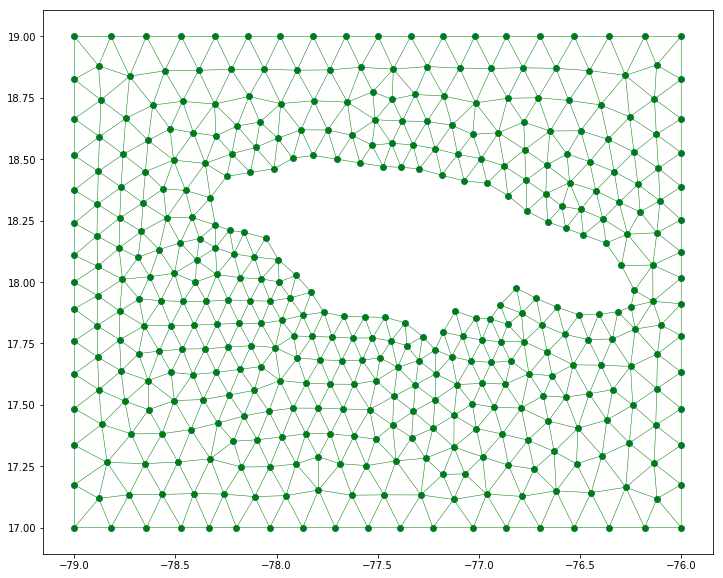

In [95]:
plt.figure(figsize=(12,10))
plt.scatter(grd.lon.values, grd.lat.values)
plt.triplot(grd.lon.values, grd.lat.values, tri3, 'go-', lw=.5, markersize=5 )


plt.show()

### Sort elements

In [96]:
gt3 = tri.loc[:,['ga','gb','gc']].copy() # make a copy
gt3.index = gt3.index.droplevel() # drop multi-index
gt3 = gt3.reset_index(drop=True)

In [97]:
# Now we need to put them in order based on the global index in elems
gt3.index = elems.global_n.values # we set the index equal to the global_n column

In [98]:
gt3 = gt3.sort_index() #sort them

In [99]:
#add nan column in place of the fourth node. This needs to be tested for quadrilaterals
gt3['gd']=np.nan

In [100]:
gt3.head()

,ga,gb,gc,gd
1,298,163,329,NaN
2,218,220,355,NaN
3,293,305,390,NaN
4,148,42,174,NaN
5,138,184,395,NaN


In [101]:
gt3 = gt3.reset_index() # reset to add more columns without problems

In [102]:
## Add mean x, y of the elememts. To be used in the output
gt3['x1'] = grd.loc[gt3['ga'].values - 1, 'lon'].values #lon of the index, -1 for python convention
gt3['y1'] = grd.loc[gt3['ga'].values - 1, 'lat'].values #lat of the index
gt3['x2'] = grd.loc[gt3['gb'].values - 1, 'lon'].values
gt3['y2'] = grd.loc[gt3['gb'].values - 1, 'lat'].values
gt3['x3'] = grd.loc[gt3['gc'].values - 1, 'lon'].values
gt3['y3'] = grd.loc[gt3['gc'].values - 1, 'lat'].values


gt3['xc'] =  gt3[['x1', 'x2', 'x3']].mean(axis=1) #mean lon of the element
gt3['yc'] =  gt3[['y1', 'y2', 'y3']].mean(axis=1)
gt3.head()

,index,ga,gb,gc,gd,x1,y1,x2,y2,x3,y3,xc,yc
0,1,298,163,329,NaN,-78.612152,18.719635,-78.726959,18.837126,-78.745728,18.665728,-78.694946,18.740829
1,2,218,220,355,NaN,-78.240143,17.926964,-78.295212,17.828188,-78.185257,17.831535,-78.240204,17.862229
2,3,293,305,390,NaN,-78.566040,17.382647,-78.505302,17.517424,-78.631928,17.480579,-78.567757,17.460217
3,4,148,42,174,NaN,-77.254791,18.876709,-77.337639,19.000000,-77.422920,18.866097,-77.338450,18.914269
4,5,138,184,395,NaN,-76.227386,17.808346,-76.117416,17.707579,-76.100327,17.825298,-76.148376,17.780408


In [103]:
## min kbe
gt3['kbe1'] = grd.loc[gt3['ga'] - 1,'kbp00'].values
gt3['kbe2'] = grd.loc[gt3['gb'] - 1,'kbp00'].values
gt3['kbe3'] = grd.loc[gt3['gc'] - 1,'kbp00'].values
#gt3['kbe4'] = grd.loc[gt3['gd'],'kbp00'].values

gt3['kbe'] = gt3[['kbe1', 'kbe2', 'kbe3']].min(axis=1)

In [104]:
gt3 = gt3.set_index('index') # set index back 

In [105]:
gt34 = gt3.loc[:,['ga','gb','gc','gd']].values # SCHISM_hgrid_face_nodes

In [106]:
np.array_equal(gt3.values[:,:3],grf.SCHISM_hgrid_face_nodes.values[:,:3]) # check with autocombine_MPI_elfe.pl values

True

## Grid's Edges

In [107]:
re.head() #indices for edges

local  global_n
core0000 0      1         4
         1      2         5
         2      3         6
         3      4         7
         4      5         8

In [108]:
edges = re.loc[re.global_n.drop_duplicates().index] # keep only one of the duplicates

In [109]:
edges.head()

local  global_n
core0000 0      1         4
         1      2         5
         2      3         6
         3      4         7
         4      5         8

In [110]:
edges.shape

(1109, 2)

Apparently it goes [b,c], [c,a], [a,b] for some reason ?

In [111]:
edgs=[]
for key in keys:
    for [ga,gb,gc] in tri.loc[key,['ga','gb','gc']].values:
        edgs.append([gb,gc])
        edgs.append([gc,ga])
        edgs.append([ga,gb])
        
edgs = np.array(edgs)
print edgs.shape
edgs

(2106, 2)


array([[220, 355],
       [355, 218],
       [218, 220],
       ...,
       [282, 315],
       [315, 283],
       [283, 282]])

In [112]:
edgs = pd.DataFrame(edgs)#make a pandas DataFrame
edgs.head()

,0,1
0,220,355
1,355,218
2,218,220
3,305,390
4,390,293


In [113]:
edgs.shape, edges.global_n.values.shape # difference due to duplicates

((2106, 2), (1109,))

In [114]:
edgs1 = edgs.apply(sorted, axis=1).drop_duplicates()
print edgs1.shape # correct shape
edgs1.head()

(1109, 2)


,0,1
0,220,355
1,218,355
2,218,220
3,305,390
4,293,390


In [115]:
# Now we need to put them in order based on the global index in edges
edgs1.index = edges.global_n.values # we set the index equal to the global_n column

In [116]:
# .. and we sort
edgs1 = edgs1.sort_index()

In [117]:
np.array_equal(edgs1.apply(sorted, axis=1).values, np.sort(grf.SCHISM_hgrid_edge_nodes.values)) # they are the same, but the orientation?

True

In [118]:
np.array_equal(edgs1.values, grf.SCHISM_hgrid_edge_nodes.values) # they are the same, but the orientation is wrong?

False

In [119]:
np.argwhere(edgs1.values != grf.SCHISM_hgrid_edge_nodes.values).shape #in many locations

(1060, 2)

### Start again with one core

In [120]:
edgs0=[]
for [ga,gb,gc] in tri.loc['core0000',['ga','gb','gc']].values:
        edgs0.append([gb,gc])
        edgs0.append([gc,ga])
        edgs0.append([ga,gb])
        
edgs0 = np.array(edgs0)

edgs0 = pd.DataFrame(edgs0)#make a pandas DataFrame
edgs0.head()

,0,1
0,220,355
1,355,218
2,218,220
3,305,390
4,390,293


In [121]:
edgs0.shape, re.loc['core0000'].shape # different because of duplication

((522, 2), (280, 2))

We see that the global edge index is less than the edges because there are duplicates in the form of [a, b],[b, a].

In [122]:
idsd = edgs0[edgs0.apply(sorted, axis=1).duplicated()].index.values # find the duplicates

In [123]:
edges01 = edgs0.drop(idsd) #drop them 

In [124]:
#apply the global index
edges01.index = re.loc['core0000','global_n'].values

In [125]:
edges01.head()

,0,1
4,220,355
5,355,218
6,218,220
7,305,390
8,390,293


In [126]:
edges01.loc[:,2] = grf.SCHISM_hgrid_edge_nodes.values[edges01.index.values-1,0] # add to the dataframe the correct results for comparison
edges01.loc[:,3] = grf.SCHISM_hgrid_edge_nodes.values[edges01.index.values-1,1]

In [127]:
#compare with the correct solution
edges01[edges01[0] != edges01[2]] # only a few differences

,0,1,2,3
223,169,123,123,169
329,263,402,402,263
328,402,300,300,402
330,387,21,21,387
68,233,387,387,233
399,236,233,233,236
680,253,236,236,253
528,279,401,401,279
322,401,343,343,401
407,378,214,214,378


### For all cores

In [128]:
edk=[]
for key in keys:
    eds=[]
    for [ga,gb,gc] in tri.loc[key,['ga','gb','gc']].values:
        eds.append([gb,gc])
        eds.append([gc,ga])
        eds.append([ga,gb])
        
    eds = np.array(eds)

    df = pd.DataFrame(eds)
    idsd = df[df.apply(sorted, axis=1).duplicated()].index.values # find the duplicates
    df_ = df.drop(idsd) #drop them 
    df_.index = re.loc[key,'global_n'].values
    
    edk.append(df_)#make a pandas DataFrame

In [129]:
edgs = pd.concat(edk) # We concatenate, however there are dublicate indices ...

In [130]:
edgs.shape

(1142, 2)

In [131]:
edgs[edgs.index.duplicated(keep=False)]

,0,1
55,13,169
80,343,253
123,214,190
183,190,75
293,269,378
343,123,279
223,169,123
329,263,402
328,402,300
807,111,140


In [132]:
#see https://stackoverflow.com/questions/13035764/remove-rows-with-duplicate-indices-pandas-dataframe-and-timeseries
edgs1 = edgs.reset_index().drop_duplicates(subset='index', keep='first').set_index('index') #drop duplicates 

In [133]:
edgs1.shape, grf.SCHISM_hgrid_edge_nodes.shape #check

((1109, 2), (1109, 2))

In [134]:
edgs1 = edgs1.sort_index() #sort index 

In [135]:
edgs1.loc[:,2] = grf.SCHISM_hgrid_edge_nodes.values[:,0] # add to the dataframe the correct results for comparison
edgs1.loc[:,3] = grf.SCHISM_hgrid_edge_nodes.values[:,1]

In [136]:
edgs1.head()

,0,1,2,3
index,,,,
1,163,329,163,329
2,329,298,329,298
3,298,163,298,163
4,220,355,220,355
5,355,218,355,218


In [137]:
edgs1 = edgs1.reset_index() #reset index to add columns

In [138]:
#mean x, y 
edgs1['x1'] = grd.loc[edgs1[0].values - 1, 'lon'].values #lon of the index, -1 for python convention
edgs1['y1'] = grd.loc[edgs1[0].values - 1, 'lat'].values #lat of the index
edgs1['x2'] = grd.loc[edgs1[1].values - 1, 'lon'].values
edgs1['y2'] = grd.loc[edgs1[1].values - 1, 'lat'].values
 
edgs1['xc'] =  edgs1[['x1', 'x2']].mean(axis=1) #mean of the edge index
edgs1['yc'] =  edgs1[['y1', 'y2']].mean(axis=1)
edgs1.head()

,index,0,1,2,3,x1,y1,x2,y2,xc,yc
0,1,163,329,163,329,-78.726959,18.837126,-78.745728,18.665728,-78.736343,18.751427
1,2,329,298,329,298,-78.745728,18.665728,-78.612152,18.719635,-78.678940,18.692681
2,3,298,163,298,163,-78.612152,18.719635,-78.726959,18.837126,-78.669556,18.778380
3,4,220,355,220,355,-78.295212,17.828188,-78.185257,17.831535,-78.240234,17.829862
4,5,355,218,355,218,-78.185257,17.831535,-78.240143,17.926964,-78.212700,17.879250


In [139]:
edgs1[edgs1[0] != edgs1[2]] # still some problems with orientation

,index,0,1,2,3,x1,y1,x2,y2,xc,yc
60,61,167,94,94,167,-76.576180,17.787008,-76.504166,17.866587,-76.540173,17.826797
67,68,233,387,387,233,-77.785370,17.683725,-77.823601,17.778366,-77.804485,17.731046
173,174,282,167,167,282,-76.534286,17.662857,-76.576180,17.787008,-76.555233,17.724933
222,223,169,123,123,169,-77.953705,17.130636,-77.792885,17.153307,-77.873295,17.141972
297,298,280,180,180,280,-77.174080,18.756838,-77.095207,18.870497,-77.134644,18.813667
321,322,401,343,343,401,-77.794792,17.288410,-77.855537,17.382608,-77.825165,17.335509
327,328,402,300,300,402,-78.401070,17.999613,-78.504799,18.035711,-78.452934,18.017662
328,329,263,402,402,263,-78.395760,18.089211,-78.401070,17.999613,-78.398415,18.044412
329,330,387,21,21,387,-77.823601,17.778366,-77.767128,17.877205,-77.795364,17.827786
398,399,236,233,233,236,-77.853905,17.588829,-77.785370,17.683725,-77.819637,17.636277


In [140]:
## min bottom index
edgs1['kbs1'] = grd.loc[edgs1[0] - 1,'kbp00'].values
edgs1['kbs2'] = grd.loc[edgs1[1] - 1,'kbp00'].values

edgs1['kbs'] = edgs1[['kbs1', 'kbs2']].min(axis=1)

In [141]:
edgs1.set_index('index') # set index again

,0,1,2,3,x1,y1,x2,y2,xc,yc,kbs1,kbs2,kbs
index,,,,,,,,,,,,,
1,163,329,163,329,-78.726959,18.837126,-78.745728,18.665728,-78.736343,18.751427,1,1,1
2,329,298,329,298,-78.745728,18.665728,-78.612152,18.719635,-78.678940,18.692681,1,1,1
3,298,163,298,163,-78.612152,18.719635,-78.726959,18.837126,-78.669556,18.778380,1,1,1
4,220,355,220,355,-78.295212,17.828188,-78.185257,17.831535,-78.240234,17.829862,1,1,1
5,355,218,355,218,-78.185257,17.831535,-78.240143,17.926964,-78.212700,17.879250,1,1,1
6,218,220,218,220,-78.240143,17.926964,-78.295212,17.828188,-78.267677,17.877576,1,1,1
7,305,390,305,390,-78.505302,17.517424,-78.631928,17.480579,-78.568615,17.499001,1,1,1
8,390,293,390,293,-78.631928,17.480579,-78.566040,17.382647,-78.598984,17.431613,1,1,1
9,293,305,293,305,-78.566040,17.382647,-78.505302,17.517424,-78.535671,17.450035,1,1,1


In [142]:
edgs1.head()

,index,0,1,2,3,x1,y1,x2,y2,xc,yc,kbs1,kbs2,kbs
0,1,163,329,163,329,-78.726959,18.837126,-78.745728,18.665728,-78.736343,18.751427,1,1,1
1,2,329,298,329,298,-78.745728,18.665728,-78.612152,18.719635,-78.678940,18.692681,1,1,1
2,3,298,163,298,163,-78.612152,18.719635,-78.726959,18.837126,-78.669556,18.778380,1,1,1
3,4,220,355,220,355,-78.295212,17.828188,-78.185257,17.831535,-78.240234,17.829862,1,1,1
4,5,355,218,355,218,-78.185257,17.831535,-78.240143,17.926964,-78.212700,17.879250,1,1,1


#### check the edges that have a problem

In [143]:
er = edgs1[edgs1[0] != edgs1[2]]
er = er.reset_index()
er.head()

,level_0,index,0,1,2,3,x1,y1,x2,y2,xc,yc,kbs1,kbs2,kbs
0,60,61,167,94,94,167,-76.576180,17.787008,-76.504166,17.866587,-76.540173,17.826797,1,1,1
1,67,68,233,387,387,233,-77.785370,17.683725,-77.823601,17.778366,-77.804485,17.731046,1,1,1
2,173,174,282,167,167,282,-76.534286,17.662857,-76.576180,17.787008,-76.555233,17.724933,1,1,1
3,222,223,169,123,123,169,-77.953705,17.130636,-77.792885,17.153307,-77.873295,17.141972,1,1,1
4,297,298,280,180,180,280,-77.174080,18.756838,-77.095207,18.870497,-77.134644,18.813667,1,1,1


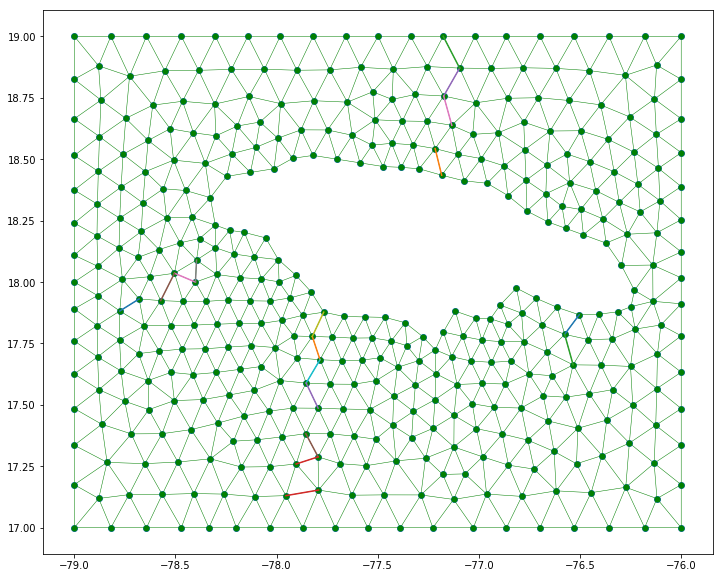

In [144]:
plt.figure(figsize=(12,10))
plt.scatter(grd.lon.values, grd.lat.values)
plt.triplot(grd.lon.values, grd.lat.values, tri3, 'go-', lw=.5, markersize=5 )
for i in range(er.shape[0]):
    plt.plot([er.loc[i,'x1'],er.loc[i,'x2']],[er.loc[i,'y1'],er.loc[i,'y2']])

plt.show()

## Combine element-wise variables

Now create a full Dataset and fill them up with the appropriate values. We use the 'wed_dry' variable as example

In [145]:
s = pd.Series(gindx.values.flatten()) # create a series with the elements node reference

In [146]:
data = pd.concat([s] * times.shape[0], axis=1) # concatenate to the number of time steps

In [147]:
data.columns=times # set columns names as the timestamps

In [148]:
data.head() # view

,2013-10-28 01:00:00,2013-10-28 02:00:00,2013-10-28 03:00:00,2013-10-28 04:00:00,2013-10-28 05:00:00,2013-10-28 06:00:00,2013-10-28 07:00:00,2013-10-28 08:00:00,2013-10-28 09:00:00,2013-10-28 10:00:00,2013-10-28 11:00:00,2013-10-28 12:00:00
0,1,1,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1
4,3,3,3,3,3,3,3,3,3,3,3,3


In [149]:
wd = data.copy() # make a copy for safery

In [150]:
print wd.loc[data['2013-10-28 01:00:00'] == 0 ].shape, out[0].wetdry_elem.values.T.shape # check shapes

(174, 12) (174, 12)


In [151]:
for time in times: #all times
    for i in range(len(keys)): # all components
        wd.loc[data[time] == i] = out[i].wetdry_elem.values.T # wetdry_elem variable

In [152]:
wd.head()

,2013-10-28 01:00:00,2013-10-28 02:00:00,2013-10-28 03:00:00,2013-10-28 04:00:00,2013-10-28 05:00:00,2013-10-28 06:00:00,2013-10-28 07:00:00,2013-10-28 08:00:00,2013-10-28 09:00:00,2013-10-28 10:00:00,2013-10-28 11:00:00,2013-10-28 12:00:00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
wd.T.shape # check shape

(12, 702)

### All variables

In [154]:
def ecombine(var,out,data,times):
    wd = data.copy()
    for time in times: #all times
        for i in range(len(keys)): # all components
            wd.loc[data[time] == i] = out[i][var].values.T #

    return wd.T


In [155]:
edic={}
for var in out[0].variables.keys():
    print out[0][var].name, out[0][var].dims, len(out[0][var].dims)
    if ('nSCHISM_hgrid_face' in out[0][var].dims) & (len(out[0][var].dims) == 2):
        wd = data.copy()
        for time in times: #all times
            for i in range(len(keys)): # all components
                wd.loc[data[time] == i] = out[i][var].values.T #
        vname = out[0][var].name
        edic[vname]=wd.T.values
        
    elif ('nSCHISM_hgrid_face' in out[0][var].dims) & ('two' in out[0][var].dims):
        wd = data.copy()
        for time in times: #all times
            for i in range(len(keys)): # all components
                wd.loc[data[time] == i] = out[i][var].values[:,:,0].T # wetdry_elem variable
        vx = wd.T
                
        wd = data.copy()
        for time in times: #all times
            for i in range(len(keys)): # all components
                wd.loc[data[time] == i] = out[i][var].values[:,:,1].T # wetdry_elem variable

        vy = wd.T

        vname = out[0][var].name
        edic[vname] = np.dstack([vx.values,vy.values])
        
    elif ('nSCHISM_hgrid_face' in out[0][var].dims) & ('nSCHISM_vgrid_layers' in out[0][var].dims):
        s=out[0][var].shape[2]
        ars=[]
        for l in range(s):
            wd = data.copy()
            for time in times: #all times
                for i in range(len(keys)): # all components
                    wd.loc[data[time] == i] = out[i][var].values[:,:,0].T # wetdry_elem variable

            ars.append(wd.T)

        vname = out[0][var].name
        edic[vname] = np.dstack([v.values for v in ars])



        

time (u'time',) 1
wetdry_elem (u'time', u'nSCHISM_hgrid_face') 2
zcor (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
elev (u'time', u'nSCHISM_hgrid_node') 2
wind_speed (u'time', u'nSCHISM_hgrid_node', u'two') 3
vertical_velocity (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
temp (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
salt (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
hvel (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers', u'two') 4


In [156]:
np.array_equal(edic['wetdry_elem'],wd.T.values) # check

True

## Combine node-wise variables

As an example we do the 'elev' variable

In [157]:
pout = out[0].elev.to_pandas().T
for i in range(1,len(keys)):
    pout = pd.concat([pout, out[i].elev.to_pandas().T])

In [158]:
pout.head()

time,3600.0,7200.0,10800.0,14400.0,18000.0,21600.0,25200.0,28800.0,32400.0,36000.0,39600.0,43200.0
nSCHISM_hgrid_node,,,,,,,,,,,,
0,-0.000555,-0.001322,-0.001953,-0.002593,-0.003135,-0.003568,-0.003490,-0.003374,-0.003200,-0.003343,-0.003586,-0.003914
1,0.000143,-0.000572,-0.001176,-0.001785,-0.002310,-0.002737,-0.002684,-0.002595,-0.002451,-0.002534,-0.002706,-0.002955
2,-0.000291,-0.001048,-0.001685,-0.002347,-0.002946,-0.003462,-0.003467,-0.003430,-0.003321,-0.003507,-0.003786,-0.004149
3,0.003939,0.004878,0.006061,0.007281,0.008379,0.009336,0.010201,0.011052,0.011806,0.012725,0.013607,0.014446
4,0.002742,0.002689,0.002674,0.002633,0.002544,0.002432,0.002548,0.002694,0.002845,0.003092,0.003303,0.003476


In [159]:
pout = pout.reset_index(drop=True) # reset index

In [160]:
pout = pout.drop(pout[grid.duplicated().values].index) # drop duplicate nodes
pout.head()

time,3600.0,7200.0,10800.0,14400.0,18000.0,21600.0,25200.0,28800.0,32400.0,36000.0,39600.0,43200.0
0,-0.000555,-0.001322,-0.001953,-0.002593,-0.003135,-0.003568,-0.003490,-0.003374,-0.003200,-0.003343,-0.003586,-0.003914
1,0.000143,-0.000572,-0.001176,-0.001785,-0.002310,-0.002737,-0.002684,-0.002595,-0.002451,-0.002534,-0.002706,-0.002955
2,-0.000291,-0.001048,-0.001685,-0.002347,-0.002946,-0.003462,-0.003467,-0.003430,-0.003321,-0.003507,-0.003786,-0.004149
3,0.003939,0.004878,0.006061,0.007281,0.008379,0.009336,0.010201,0.011052,0.011806,0.012725,0.013607,0.014446
4,0.002742,0.002689,0.002674,0.002633,0.002544,0.002432,0.002548,0.002694,0.002845,0.003092,0.003303,0.003476


In [161]:
pout.index = cnodes.values - 1 # reindex based on the global index -1 for the python convention

In [162]:
pout.head()

time,3600.0,7200.0,10800.0,14400.0,18000.0,21600.0,25200.0,28800.0,32400.0,36000.0,39600.0,43200.0
217,-0.000555,-0.001322,-0.001953,-0.002593,-0.003135,-0.003568,-0.003490,-0.003374,-0.003200,-0.003343,-0.003586,-0.003914
219,0.000143,-0.000572,-0.001176,-0.001785,-0.002310,-0.002737,-0.002684,-0.002595,-0.002451,-0.002534,-0.002706,-0.002955
354,-0.000291,-0.001048,-0.001685,-0.002347,-0.002946,-0.003462,-0.003467,-0.003430,-0.003321,-0.003507,-0.003786,-0.004149
292,0.003939,0.004878,0.006061,0.007281,0.008379,0.009336,0.010201,0.011052,0.011806,0.012725,0.013607,0.014446
304,0.002742,0.002689,0.002674,0.002633,0.002544,0.002432,0.002548,0.002694,0.002845,0.003092,0.003303,0.003476


In [163]:
elev = pout.sort_index() #sort with the global index

In [164]:
#reindex for final version
elev = elev.reset_index(drop=True)

In [165]:
elev.columns = times # set time stamp 

In [166]:
elev = elev.T # transpose to set time as index

In [167]:
elev.head()

,0,1,2,3,4,5,6,7,8,9,...,397,398,399,400,401,402,403,404,405,406
2013-10-28 01:00:00,0.0,0.0,0.0,0.0,-0.001902,0.0,0.0,0.0,0.0,0.0,...,0.002222,0.001423,-0.000130,0.001315,-0.000142,-0.001589,-0.000256,-0.000565,-0.001262,-0.001577
2013-10-28 02:00:00,0.0,0.0,0.0,0.0,-0.002679,0.0,0.0,0.0,0.0,0.0,...,0.001655,0.001627,-0.000503,0.001110,-0.000921,-0.002359,0.000428,-0.000860,-0.002006,-0.001987
2013-10-28 03:00:00,0.0,0.0,0.0,0.0,-0.002698,0.0,0.0,0.0,0.0,0.0,...,0.001207,0.001838,-0.000760,0.000970,-0.001581,-0.002888,0.001109,-0.000944,-0.002569,-0.002209
2013-10-28 04:00:00,0.0,0.0,0.0,0.0,-0.002696,0.0,0.0,0.0,0.0,0.0,...,0.000843,0.001945,-0.000987,0.000845,-0.002211,-0.003442,0.001815,-0.000861,-0.003151,-0.002397
2013-10-28 05:00:00,0.0,0.0,0.0,0.0,-0.002628,0.0,0.0,0.0,0.0,0.0,...,0.000508,0.001895,-0.001210,0.000714,-0.002732,-0.003879,0.002615,-0.000587,-0.003644,-0.002567


In [168]:
sl = elev.loc['2013-10-28 04:00:00'].values

In [169]:
sl.min(), sl.max(), sl.mean()

(-0.012861124, 0.018505627, -4.9997358e-05)

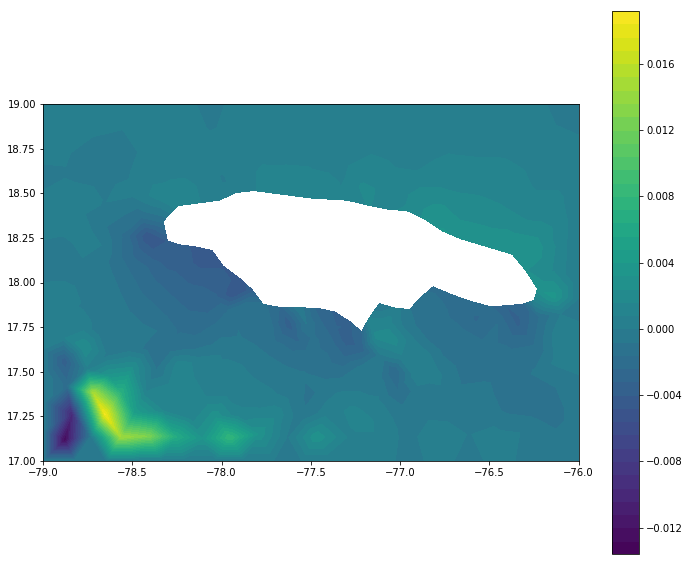

In [170]:
#test
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal')
plt.tricontourf(grd.lon.values, grd.lat.values, tri3, sl, 50 )
plt.colorbar()
plt.show()

### All variables

In [171]:
drop_mask = grid.duplicated().values # save the mask

In [172]:
drop_mask.shape

(444,)

In [173]:
#Function for combining variables
def combine(ars, drop_mask, cnodes, times):
        pout = ars[0].to_pandas().T
        for f in ars[1:]:
            pout = pd.concat([pout, f.to_pandas().T])
        
        pout = pout.reset_index(drop=True) # reset index
        
        pout = pout.drop(pout[drop_mask].index) # drop duplicate nodes
        
        pout.index = cnodes.values - 1 # reindex based on the global index -1 for the python convention
        
        pout = pout.sort_index() #sort with the global index
        
        
        pout = pout.reset_index(drop=True)#reindex for final version
        
        pout.columns = times # set time stamp 
        
        return pout.T # transpose to set time as index

In [174]:
vdic={}
for var in out[0].variables.keys():
    print out[0][var].name, out[0][var].dims, len(out[0][var].dims)
    if ('nSCHISM_hgrid_node' in out[0][var].dims) & (len(out[0][var].dims) == 2):
        ars = [v[out[0][var].name] for v in out]
       
        v = combine(ars, drop_mask, cnodes, times)
        
        vdic[out[0][var].name] = v.values
        
    elif ('nSCHISM_hgrid_node' in out[0][var].dims) & ('two' in out[0][var].dims) & (len(out[0][var].dims) == 3):
        ars1 = [v[out[0][var].name][:,:,0] for v in out]
        vx = combine(ars1, drop_mask, cnodes, times)
        ars2 = [v[out[0][var].name][:,:,1] for v in out]
        vy = combine(ars2, drop_mask, cnodes, times)
        
        vname = out[0][var].name
        vdic[vname] = np.dstack([vx.values,vy.values])
        
    elif ('nSCHISM_hgrid_node' in out[0][var].dims) & ('nSCHISM_vgrid_layers' in out[0][var].dims) & (len(out[0][var].dims) == 3):
        s=out[0][var].shape[2]
        ars=[]
        for l in range(s):
            arsi = [v[out[0][var].name][:,:,l] for v in out]
            ars.append(combine(arsi, drop_mask, cnodes, times))

        vname = out[0][var].name
        vdic[vname] = np.dstack([v.values for v in ars])

    elif ('nSCHISM_hgrid_node' in out[0][var].dims) & ('nSCHISM_vgrid_layers' in out[0][var].dims) & ('two' in out[0][var].dims) & (len(out[0][var].dims) == 4):
        s=out[0][var].shape[2]
        ars=[]
        for l in range(s):
            arsx = [v[out[0][var].name][:,:,l,0] for v in out]
            vx = combine(arsx, drop_mask, cnodes, times)
            arsy = [v[out[0][var].name][:,:,l,1] for v in out]
            vy = combine(arsy, drop_mask, cnodes, times)
            ars.append(np.dstack([vx.values,vy.values]))
        
        vname = out[0][var].name
        vdic[vname] = np.stack([a for a in ars], axis=2) # stack correctly
        

time (u'time',) 1
wetdry_elem (u'time', u'nSCHISM_hgrid_face') 2
zcor (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
elev (u'time', u'nSCHISM_hgrid_node') 2
wind_speed (u'time', u'nSCHISM_hgrid_node', u'two') 3
vertical_velocity (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
temp (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
salt (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers') 3
hvel (u'time', u'nSCHISM_hgrid_node', u'nSCHISM_vgrid_layers', u'two') 4


In [175]:
vdic.keys()

[u'wind_speed',
 u'hvel',
 u'temp',
 u'zcor',
 u'elev',
 u'vertical_velocity',
 u'salt']

## Create output structure

### General properties

In [176]:
sigms = header2.loc[:,sigmas].values.flatten() # get sigmas

In [177]:
iwet_dry = 0  # defined by the user
ihgrid_id = -2147483647 # defined by user - 0,dummy_dim,ihgrid_id

### Xarray for element-based variables

In [178]:
edic.keys()

[u'wetdry_elem']

In [179]:
xrdic={}
for key in edic.iterkeys():
    xrdic.update({key:([x for x in out[0][key].dims],edic[key])})

In [180]:
xe = xr.Dataset(xrdic,coords={u'time':times, u'sigma': sigms })

In [181]:
xe

<xarray.Dataset>
Dimensions:      (nSCHISM_hgrid_face: 702, sigma: 2, time: 12)
Coordinates:
  * sigma        (sigma) float64 -1.0 0.0
  * time         (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nSCHISM_hgrid_face
Data variables:
    wetdry_elem  (time, nSCHISM_hgrid_face) float64 0.0 0.0 1.0 0.0 0.0 0.0 ...

In [182]:
#Set Attrs (this needs some automation)
xe.wetdry_elem.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'elem', 'data_vertical_center' : 'full', 'i23d' : 4, 'ivs' : 1}

### Xarray for node-based variables

In [183]:
vdic.keys()

[u'wind_speed',
 u'hvel',
 u'temp',
 u'zcor',
 u'elev',
 u'vertical_velocity',
 u'salt']

In [184]:
xrdic={}
for key in vdic.iterkeys():
    xrdic.update({key:([x for x in out[0][key].dims],vdic[key])})

In [185]:
xn = xr.Dataset(xrdic,coords={u'time':times, u'sigma': sigms })

In [186]:
xn

<xarray.Dataset>
Dimensions:            (nSCHISM_hgrid_node: 407, nSCHISM_vgrid_layers: 2, sigma: 2, time: 12, two: 2)
Coordinates:
  * sigma              (sigma) float64 -1.0 0.0
  * time               (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_vgrid_layers, two
Data variables:
    wind_speed         (time, nSCHISM_hgrid_node, two) float32 -8.126666 ...
    hvel               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, two) float32 -0.0009977188 ...
    elev               (time, nSCHISM_hgrid_node) float32 0.0 0.0 0.0 0.0 ...
    vertical_velocity  (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 2.5050538e-05 ...
    temp               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 10.0 ...
    salt               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 0.0 ...
    zcor               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 -2894.0 ...

In [187]:
#Set Attrs
xn.salt.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 2, 'ivs' : 1}
xn.zcor.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 2, 'ivs' : 1}
xn.temp.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 2, 'ivs' : 1}
xn.vertical_velocity.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 2, 'ivs' : 1}
xn.hvel.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 2, 'ivs' : 2}
xn.elev.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 1, 'ivs' : 1}
xn.wind_speed.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 1, 'ivs' : 2}
#xv.dahv.attrs = {'mesh' : 'SCHISM_hgrid', 'data_horizontal_center' : 'node', 'data_vertical_center' : 'full', 'i23d' : 1, 'ivs' : 2}

### Xarray for Grid variables

In [188]:
header2 #remember ...

,start_year,start_month,start_day,start_hour,utc_start,nrec,dtout,nspool,nvrt,kz,h0,h_s,h_c,theta_b,theta_f,ics,sigma_0,sigma_1
0,2013,10,28,0.0,0.0,4,3600.0,9,2,1,0.5,1000000.0,40.0,1.0,0.0001,2,-1.0,0.0


In [189]:
header2.nvrt, header2.kz

(0    2
 Name: nvrt, dtype: int64, 0    1
 Name: kz, dtype: int64)

In [190]:
#compute cs
klev = np.arange(header2.kz,header2.nvrt+1)
k = klev-header2.kz.values


cs=np.zeros(k)

cs=(1-header2.theta_b.values)*np.sinh(header2.theta_f.values*sigms[k])/np.sinh(header2.theta_f.values)+ \
    header2.theta_b.values*(np.tanh(header2.theta_f.values*(sigms[k]+0.5))-np.tanh(header2.theta_f.values*0.5))/2/np.tanh(header2.theta_f.values*0.5)

cs

array([-1.,  0.])

In [191]:
xg = xr.Dataset({u'SCHISM_hgrid' : ([u'one'], [ihgrid_id]),
                 u'SCHISM_hgrid_face_nodes' : ([u'nSCHISM_hgrid_face', u'nMaxSCHISM_hgrid_face_nodes'], gt34),
                 u'SCHISM_hgrid_edge_nodes' : ([u'nSCHISM_hgrid_edge', u'two'], edgs1[[0,1]].values),
                 u'SCHISM_hgrid_node_x' : ([u'nSCHISM_hgrid_node'], grd.lon.values),
                 u'SCHISM_hgrid_node_y' : ([u'nSCHISM_hgrid_node'], grd.lat.values),
                 u'node_bottom_index' : ([u'nSCHISM_hgrid_node'], grd.kbp00.values),
                 u'SCHISM_hgrid_face_x' : ([u'nSCHISM_hgrid_face'], gt3.loc[:,'xc'].values),
                 u'SCHISM_hgrid_face_y' : ([u'nSCHISM_hgrid_face'], gt3.loc[:,'yc'].values),                 
                 u'ele_bottom_index': ([u'nSCHISM_hgrid_face'], gt3.kbe.values ),
                 u'SCHISM_hgrid_edge_x' : ([u'nSCHISM_hgrid_edge'], edgs1['xc'].values),
                 u'SCHISM_hgrid_edge_y' : ([u'nSCHISM_hgrid_edge'], edgs1['yc'].values ),
                 u'edge_bottom_index' : ([u'nSCHISM_hgrid_edge'], edgs1.kbs.values),                 
                 u'depth': ([u'nSCHISM_hgrid_node'], grd.depth.values),
                 u'dry_value_flag' : ([u'one'], [iwet_dry]),
                 u'coordinate_system_flag' : ([u'one'], header2.loc[:,'ics'].values),                
                 u'minimum_depth': ([u'one'], header2.loc[:,'h0'].values),
                 u'sigma_h_c' : ([u'one'], header2.loc[:,'h_c'].values),
                 u'sigma_theta_b': ([u'one'], header2.loc[:,'theta_b'].values),
                 u'sigma_theta_f' : ([u'one'], header2.loc[:,'theta_f'].values),
                 u'sigma_maxdepth' : ([u'one'], header2.loc[:,'h_s'].values),
                 u'Cs' : (['sigma'], cs)},
                     coords={u'time':times, u'sigma': sigms })

In [192]:
xg

<xarray.Dataset>
Dimensions:                  (nMaxSCHISM_hgrid_face_nodes: 4, nSCHISM_hgrid_edge: 1109, nSCHISM_hgrid_face: 702, nSCHISM_hgrid_node: 407, one: 1, sigma: 2, time: 12, two: 2)
Coordinates:
  * sigma                    (sigma) float64 -1.0 0.0
  * time                     (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nMaxSCHISM_hgrid_face_nodes, nSCHISM_hgrid_edge, nSCHISM_hgrid_face, nSCHISM_hgrid_node, one, two
Data variables:
    sigma_theta_f            (one) float64 0.0001
    ele_bottom_index         (nSCHISM_hgrid_face) int64 1 1 1 1 1 1 1 1 1 1 ...
    coordinate_system_flag   (one) int64 2
    SCHISM_hgrid_edge_nodes  (nSCHISM_hgrid_edge, two) int64 163 329 329 298 ...
    node_bottom_index        (nSCHISM_hgrid_node) int64 1 1 1 1 1 1 1 1 1 1 ...
    minimum_depth            (one) float64 0.5
    dry_value_flag           (one) int64 0
    sigma_theta_b            (one) float64 1.0
    sigma_maxdepth           (one) float64 1e+06
 

### Set attrs

In [193]:
#Choose attrs
if header2.ics.values == 1:
    lat_coord_standard_name = 'projection_x_coordinate'
    lon_coord_standard_name = 'projection_y_coordinate'
    x_units = 'm'
    y_units = 'm'
    lat_str_len = 23
    lon_str_len = 23
else:
    lat_coord_standard_name = 'latitude'
    lon_coord_standard_name = 'longitude'
    x_units = 'degrees_north'
    y_units = 'degrees_east'
    lat_str_len = 8
    lon_str_len = 9

In [194]:
#set Attrs
xg.SCHISM_hgrid_node_x.attrs = {'long_name' : 'node x-coordinate', 'standard_name' : lon_coord_standard_name , 'units' : x_units, 'mesh' : 'SCHISM_hgrid'}

xg.SCHISM_hgrid_node_y.attrs = {'long_name' : 'node y-coordinate', 'standard_name' : lat_coord_standard_name , 'units' : y_units, 'mesh' : 'SCHISM_hgrid'}

xg.depth.attrs = {'long_name' : 'Bathymetry', 'units' : 'meters', 'positive' : 'down', 'mesh' : 'SCHISM_hgrid', 'location' : 'node'}

xg.sigma_h_c.attrs = {'long_name' : 'ocean_s_coordinate h_c constant', 'units' : 'meters', 'positive' : 'down'}

xg.sigma_theta_b.attrs = {'long_name' : 'ocean_s_coordinate theta_b constant'}

xg.sigma_theta_f.attrs = {'long_name' : 'ocean_s_coordinate theta_f constant'}

xg.sigma_maxdepth.attrs = {'long_name' : 'ocean_s_coordinate maximum depth cutoff (mixed s over z bound...', 'units' : 'meters', 'positive' : 'down'}

xg.Cs.attrs = {'long_name' : 'Function C(s) at whole levels', 'positive' : 'up' }

xg.dry_value_flag.attrs = {'values' : '0: use last-wet value; 1: use junk'}

xg.SCHISM_hgrid_face_nodes.attrs = {'long_name' : 'Horizontal Element Table', 'cf_role' : 'face_node_connectivity' , 'start_index' : 1}

xg.SCHISM_hgrid_edge_nodes.attrs = {'long_name' : 'Map every edge to the two nodes that it connects', 'cf_role' : 'edge_node_connectivity' , 'start_index' : 1}

xg.SCHISM_hgrid_edge_x.attrs = {'long_name' : 'x_coordinate of 2D mesh edge' , 'standard_name' : lon_coord_standard_name, 'units' : 'm', 'mesh' : 'SCHISM_hgrid'}

xg.SCHISM_hgrid_edge_y.attrs = {'long_name' : 'y_coordinate of 2D mesh edge' , 'standard_name' : lat_coord_standard_name, 'units' : 'm', 'mesh' : 'SCHISM_hgrid'}

xg.SCHISM_hgrid_face_x.attrs = {'long_name' : 'x_coordinate of 2D mesh face' , 'standard_name' : lon_coord_standard_name, 'units' : 'm', 'mesh' : 'SCHISM_hgrid'}

xg.SCHISM_hgrid_face_y.attrs = {'long_name' : 'y_coordinate of 2D mesh face' , 'standard_name' : lat_coord_standard_name, 'units' : 'm', 'mesh' : 'SCHISM_hgrid'}

xg.SCHISM_hgrid.attrs = {'long_name' : 'Topology data of 2d unstructured mesh',
                           'topology_dimension' : 2,
                           'cf_role' : 'mesh_topology',
                           'node_coordinates' : 'SCHISM_hgrid_node_x SCHISM_hgrid_node_y',
                           'face_node_connectivity' : 'SCHISM_hgrid_face_nodes',
                           'edge_coordinates' : 'SCHISM_hgrid_edge_x SCHISM_hgrid_edge_y',
                           'face_coordinates' : 'SCHISM_hgrid_face_x SCHISM_hgrid_face_y',
                           'edge_node_connectivity' : 'SCHISM_hgrid_edge_nodes'
                          }

xg.node_bottom_index.attrs = {'long_name' : 'bottom level index at each node' , 'units' : 'non-dimensional', 'mesh' : 'SCHISM_hgrid', 'location' : 'node',
    'start_index' : 1}

xg.ele_bottom_index.attrs = {'long_name' : 'bottom level index at each element' , 'units' : 'non-dimensional', 'mesh' : 'SCHISM_hgrid', 'location' : 'elem',
    'start_index' : 1}

xg.edge_bottom_index.attrs = {'long_name' : 'bottom level index at each edge' , 'units' : 'non-dimensional', 'mesh' : 'SCHISM_hgrid', 'location' : 'edge',
    'start_index' : 1}

### merge them

In [195]:
dat = xr.merge([xg,xe,xn])

In [196]:
dat.attrs = {'Conventions': 'CF-1.0, UGRID-1.0', 'title': 'SCHISM Model output', 'source': 'SCHISM model output version v10', 'references': 'http://ccrm.vims.edu/schismweb/',
             'history': 'created by pyPoseidon', 'comment': 'SCHISM Model output', 'type': 'SCHISM Model output', 'VisIT_plugin': 'https://schism.water.ca.gov/library/-/document_library/view/3476283' }

In [197]:
dat

<xarray.Dataset>
Dimensions:                  (nMaxSCHISM_hgrid_face_nodes: 4, nSCHISM_hgrid_edge: 1109, nSCHISM_hgrid_face: 702, nSCHISM_hgrid_node: 407, nSCHISM_vgrid_layers: 2, one: 1, sigma: 2, time: 12, two: 2)
Coordinates:
  * sigma                    (sigma) float64 -1.0 0.0
  * time                     (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nMaxSCHISM_hgrid_face_nodes, nSCHISM_hgrid_edge, nSCHISM_hgrid_face, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, one, two
Data variables:
    sigma_theta_f            (one) float64 0.0001
    ele_bottom_index         (nSCHISM_hgrid_face) int64 1 1 1 1 1 1 1 1 1 1 ...
    coordinate_system_flag   (one) int64 2
    SCHISM_hgrid_edge_nodes  (nSCHISM_hgrid_edge, two) int64 163 329 329 298 ...
    node_bottom_index        (nSCHISM_hgrid_node) int64 1 1 1 1 1 1 1 1 1 1 ...
    minimum_depth            (one) float64 0.5
    dry_value_flag           (one) int64 0
    sigma_theta_b            (one) float64 1.0
   

## Save to netcdf

In [198]:
dat.to_netcdf(folder+'outputs/test.nc')

### test read

In [199]:
ct = xr.open_mfdataset(folder+'outputs/test.nc')

In [200]:
ct

<xarray.Dataset>
Dimensions:                  (nMaxSCHISM_hgrid_face_nodes: 4, nSCHISM_hgrid_edge: 1109, nSCHISM_hgrid_face: 702, nSCHISM_hgrid_node: 407, nSCHISM_vgrid_layers: 2, one: 1, sigma: 2, time: 12, two: 2)
Coordinates:
  * sigma                    (sigma) float64 -1.0 0.0
  * time                     (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nMaxSCHISM_hgrid_face_nodes, nSCHISM_hgrid_edge, nSCHISM_hgrid_face, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, one, two
Data variables:
    sigma_theta_f            (one) float64 dask.array<shape=(1,), chunksize=(1,)>
    ele_bottom_index         (nSCHISM_hgrid_face) int64 dask.array<shape=(702,), chunksize=(702,)>
    coordinate_system_flag   (one) int64 dask.array<shape=(1,), chunksize=(1,)>
    SCHISM_hgrid_edge_nodes  (nSCHISM_hgrid_edge, two) int64 dask.array<shape=(1109, 2), chunksize=(1109, 2)>
    node_bottom_index        (nSCHISM_hgrid_node) int64 dask.array<shape=(407,), chunksize=(407,)>
    

In [201]:
#compare to autocombine_MPI_elfe.pl values
for key in grf.variables.keys():
     if not grf[key].equals(ct[key]): print key

SCHISM_hgrid_edge_nodes
SCHISM_hgrid_node_x
SCHISM_hgrid_node_y
SCHISM_hgrid_face_x
SCHISM_hgrid_face_y
SCHISM_hgrid_edge_x
SCHISM_hgrid_edge_y
sigma_theta_f
zcor


### Address the Failed comparisons

In [202]:
# Values for SCHISM_hgrid_face_x check within machine accuracy
np.max(np.abs(grf.SCHISM_hgrid_face_x.values-ct.SCHISM_hgrid_face_x.values))

7.66266275320504e-06

In [203]:
# Values for SCHISM_hgrid_face_y check within machine accuracy
np.max(np.abs(grf.SCHISM_hgrid_face_y.values-ct.SCHISM_hgrid_face_y.values))

1.9390380856521006e-06

In [204]:
# Values for SCHISM_hgrid_edge_x check within machine accuracy
np.max(np.abs(grf.SCHISM_hgrid_edge_x.values-ct.SCHISM_hgrid_edge_x.values))

3.861132825022651e-06

In [205]:
# Values for SCHISM_hgrid_edge_x check within machine accuracy
np.max(np.abs(grf.SCHISM_hgrid_edge_y.values-ct.SCHISM_hgrid_edge_y.values))

1.0015136737706598e-06

In [206]:
# Values for SCHISM_hgrid_node_x check within machine accuracy
np.max(np.abs(grf.SCHISM_hgrid_node_x.values-ct.SCHISM_hgrid_node_x.values))

4.970702605078259e-08

In [207]:
# Values for SCHISM_hgrid_node_x check within machine accuracy
np.max(np.abs(grf.SCHISM_hgrid_node_y.values-ct.SCHISM_hgrid_node_y.values))

4.992675783910272e-08

In [208]:
# Values for theta_b check within machine accuracy
np.max(np.abs(grf.sigma_theta_f.values-ct.sigma_theta_f.values))

2.6212498426166075e-14

In [209]:
# Values for zcor check within machine accuracy
b1 = np.ma.log(grf.zcor.values) #mask Inf values
b2 = np.ma.log(ct.zcor.values)
np.max(np.abs(b1-b2))

0.0

In [210]:
# The above problem with the edges orientation for some elements
np.argwhere(grf.SCHISM_hgrid_edge_nodes.values!=ct.SCHISM_hgrid_edge_nodes.values)

array([[ 60,   0],
       [ 60,   1],
       [ 67,   0],
       [ 67,   1],
       [173,   0],
       [173,   1],
       [222,   0],
       [222,   1],
       [297,   0],
       [297,   1],
       [321,   0],
       [321,   1],
       [327,   0],
       [327,   1],
       [328,   0],
       [328,   1],
       [329,   0],
       [329,   1],
       [398,   0],
       [398,   1],
       [406,   0],
       [406,   1],
       [507,   0],
       [507,   1],
       [509,   0],
       [509,   1],
       [527,   0],
       [527,   1],
       [679,   0],
       [679,   1],
       [699,   0],
       [699,   1],
       [994,   0],
       [994,   1]])